In [1]:
# python
import os, sys, pickle
from itertools import combinations_with_replacement, combinations, product
from collections import OrderedDict

# stats
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.api import OLS
from pandas.api.types import CategoricalDtype

# plot
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

# neural networks
import torch, torch.utils.model_zoo  # required to load nets
from torchvision.models.feature_extraction import (
    get_graph_node_names,
    create_feature_extractor,
)

# analysis code
from lib.transforms import VisualPriorRepresentation
from lib.functions_second_analysis import *
from lib.functions_scripting import *

PATH_IMAGES = "../images and ratings/imageversions_256"
PATH_RATINGS = "../images and ratings/ratings"

# !! correlations, invert sign for integration
PATH_INTEGRATION = "../data csv/integration"
PATH_INTEGRATION_MAXPOOL = "../data csv/integration maxpool"
PATH_INTEGRATION_AVERAGE = "../data csv/integration average"

PATH_IBCORR = "../data csv/ibcorr"
PATH_IBCORR_AVERAGE = "../data csv/ibcorr average"
PATH_IBCORR_MAXPOOL = "../data csv/ibcorr maxpool"

PATH_RESULTS = "../results"
PATH_PLOTS = "../plots"

beauty_ratings = load_ratings(PATH_RATINGS)

# load

In [ ]:
_models = MODEL_NAMES
_studies = "short presentation"
_datasets = "places1"
_scales = "scale4"

In [3]:
_models = MODEL_NAMES
_studies = STUDY_NAMES
_datasets = DATASET_NAMES
_scales = SCALE_NAMES

In [2]:
_models = NETS_ALL
_studies = STUDY_NAMES
_datasets = DATASET_NAMES
_scales = SCALE_NAMES

In [ ]:
# subselect models that have significant predictions at scale4
models_to_remove = set(
    ["edge_occlusion", "inpainting", "keypoints", "normal", "jigsaw"]
)
_models = list(set(MODEL_NAMES).difference(models_to_remove))

In [2]:
# no subselections
dfi = load_integration(PATH_INTEGRATION)
dfibc = load_ibcorr(PATH_IBCORR)

In [4]:
# unblocked data
_blocking = None
_layers = slice(None)

dfi = load_integration(PATH_INTEGRATION)
dfibc = load_ibcorr(PATH_IBCORR)

dfi = dfi.sort_index().loc[(_models, _datasets, _scales, slice(None), _layers)]
dfibc = dfibc.sort_index().loc[(_models, _studies, _scales, _layers)]

In [3]:
# averaged data
_blocking = "average"
_layers = slice(None)

dfi = load_integration(PATH_INTEGRATION_AVERAGE)
dfibc = load_ibcorr(PATH_IBCORR_AVERAGE)

dfi = dfi.sort_index().loc[(_models, _datasets, _scales, slice(None), _layers)]
dfibc = dfibc.sort_index().loc[(_models, _studies, _scales, _layers)]

In [68]:
# maxpooled data
_blocking = "maxpool"
_layers = slice(None)

dfi = load_integration(PATH_INTEGRATION_MAXPOOL)
dfibc = load_ibcorr(PATH_IBCORR_MAXPOOL)

dfi = dfi.sort_index().loc[(_models, _datasets, _scales, slice(None), _layers)]
dfibc = dfibc.sort_index().loc[(_models, _studies, _scales, _layers)]

# Target 01: differences in ib-corr

absoloute difference in correlation in each layer, summed up. <br>
Optional: Normalized with 2 (spearman correlation range) * num_layers 

## version 1: absoloute differences

In [3]:
target_rdm_absdiff = (
    (
        dfibc.unstack("model")
        .groupby(["study", "scale"])
        .apply(calculate_rdm, ctype="absdiff")
    )
    .droplevel(None)
    .droplevel(None, axis=1)
)

In [ ]:
# df = dfibc.unstack("layer")
# rdm_target_absdiff = pd.DataFrame(0, index=_models, columns=_models)

# for c1, c2 in combinations(_models, 2):
#     # sum of absoloute differences (easier, no correlation of correlated correlation coefficients)
#     rdm_target_absdiff.loc[c1, c2] = (df.loc[c1] - df.loc[c2]).abs().sum()
#     rdm_target_absdiff.loc[c2, c1] = (df.loc[c1] - df.loc[c2]).abs().sum()

# # norming dissimilarity: sum_abs_diff / (num_layers * 2)
# sns.heatmap(
#     rdm_target_absdiff,
#     xticklabels=rdm_target_absdiff.columns,
#     yticklabels=rdm_target_absdiff.index,
# )
# target_rdm = rdm_target_absdiff

## version 2: correlation

In [ ]:
# TODO: add correlate correlations
# TODO check correct oder of models for this
df = dfibc.unstack("layer")
rdm_target_corrwise = pd.DataFrame(0, index=_models, columns=_models)

for c1, c2 in combinations(_models, 2):
    rdm_target_corrwise.loc[c1, c2] = pearsonr(df.loc[c1], df.loc[c2])[0]
    rdm_target_corrwise.loc[c2, c1] = pearsonr(df.loc[c1], df.loc[c2])[0]

# norming dissimilarity: sum_abs_diff / (num_layers * 2)
sns.heatmap(
    rdm_target_corrwise,
    xticklabels=rdm_target_corrwise.columns,
    yticklabels=rdm_target_corrwise.index,
)
target_rdm = rdm_target_corrwise

# Predictor 1: semantic-2d-3d
Network grouping according to Radek paper <br>
[Finished predictor RDM ](#predictor-rdm-semantic-2d-3d)

In [6]:
factor1_rdms = dfi.unstack("model").groupby(["layer","dataset", "scale"]).apply(calculate_rdm)

In [ ]:
# factor1_rdms.to_hdf(os.path.join(PATH_RESULTS, "sem_2d_3d", "all.h5"), key="factor1_rdms")
# factor1_rdms.to_hdf(os.path.join(PATH_RESULTS, "sem_2d_3d", "sem2d3d_nets.h5"), key="factor1_rdms")
# factor1_rdms.to_hdf(os.path.join(PATH_RESULTS, "sem_2d_3d", "sem2d3d_nets_averaged.h5"), key="factor1_rdms")
factor1_rdms.to_hdf(os.path.join(PATH_RESULTS, "sem_2d_3d", "sem2d3d_nets_maxpool.h5"), key="factor1_rdms")

In [ ]:
factor1_rdms = pd.read_hdf(
    os.path.join(PATH_RESULTS, "sem_2d_3d", "all_unblocked.h5"), key="factor1_rdms"
)

In [ ]:
factor1_rdms = pd.read_hdf(
    os.path.join(PATH_RESULTS, "sem_2d_3d", "sem2d3d_nets_unblocked.h5"), key="factor1_rdms"
)

In [ ]:
factor1_rdms = pd.read_hdf(
    os.path.join(PATH_RESULTS, "sem_2d_3d", "sem2d3d_nets_maxpool.h5"), key="factor1_rdms"
)

In [ ]:
factor1_rdms = pd.read_hdf(
    os.path.join(PATH_RESULTS, "sem_2d_3d", "sem2d3d_nets_averaged.h5"), key="factor1_rdms"
)

#### predictor RDM

In [ ]:
_models = factor1_rdms.columns.get_level_values("model")

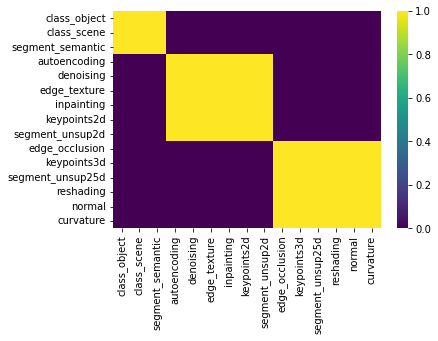

In [117]:
# model RDM
model_rdm = pd.DataFrame(
    np.full((len(NETS_ALL), len(NETS_ALL)), np.nan), columns=NETS_ALL, index=NETS_ALL
)

for combi in combinations_with_replacement(NETS_ALL, 2):
    if (
        combi in combinations_with_replacement(NETS_SEMANTIC, 2)
        or combi in combinations_with_replacement(NETS_2D, 2)
        or combi in combinations_with_replacement(NETS_3D, 2)
    ):
        model_rdm.loc[combi] = 1
        model_rdm.loc[tuple(reversed(combi))] = 1
    else:
        model_rdm.loc[combi] = 0
        model_rdm.loc[tuple(reversed(combi))] = 0
sns.heatmap(model_rdm, cmap="viridis")


In [118]:
predictor_rdm_1 = model_rdm

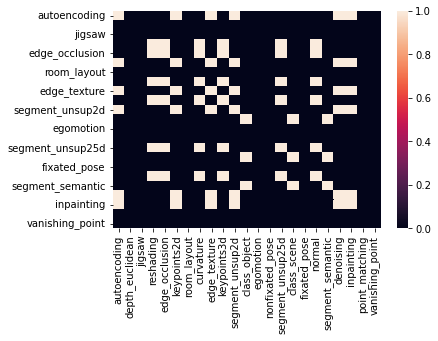

In [124]:
predictor_rdm_1 = pd.DataFrame(0, index=_models, columns=_models)
for c1, c2 in combinations_with_replacement(_models, 2):
    if c1 in model_rdm.index and c2 in model_rdm.index:
        predictor_rdm_1.loc[c1, c2] = model_rdm.loc[c1, c2]
        predictor_rdm_1.loc[c2, c1] = model_rdm.loc[c2, c1]
    else:
        predictor_rdm_1.loc[c1, c2] = 0
        predictor_rdm_1.loc[c2, c1] = 0
sns.heatmap(predictor_rdm_1)

In [ ]:
pred

####

In [57]:
correlations_with_model = (
    factor1_rdms.groupby(["layer", "dataset", "scale"])
    .apply(correlate_rdms, rdm2=predictor_rdm_1, correlation="spearman")
    .to_frame()
)

correlations_with_model = (
    correlations_with_model.assign(
        correlation=correlations_with_model[0].transform(lambda x: x[0]),
        pvalue=correlations_with_model[0].transform(lambda x: x[1]),
    )
    .drop(0, axis=1)
    .unstack("layer")
)

dtype_scale = CategoricalDtype(categories=SCALE_NAMES, ordered=True)

correlations_with_model = (
    correlations_with_model.droplevel("scale")
    .assign(
        scale=correlations_with_model.index.get_level_values("scale").astype(
            dtype_scale
        )
    )
    .set_index("scale", append=True)
    .sort_index()
)

In [62]:
def sem2d3d_plot_modelcorr(d):
    ax = d.correlation.T.plot()

    alpha = 0.05
    n_cols = d.correlation.columns.size
    masks = (d.pvalue < (alpha/n_cols)).T #mcc


    for ofs, scale in enumerate(d.index):
        mask = masks[scale].values
        x = np.arange(n_cols).reshape(-1, 1)[mask].squeeze()
        h = np.full(x.shape, d.correlation.max().max()) + 5 * 0.012 - ofs * 0.012 + 0.03
        ax.scatter(x, h)
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

""


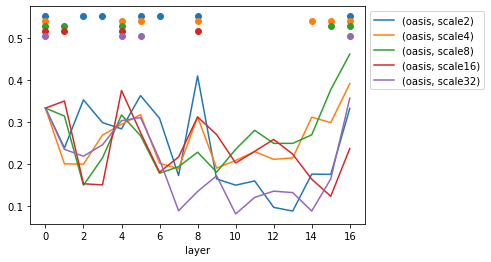

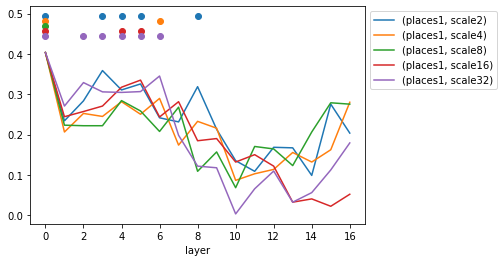

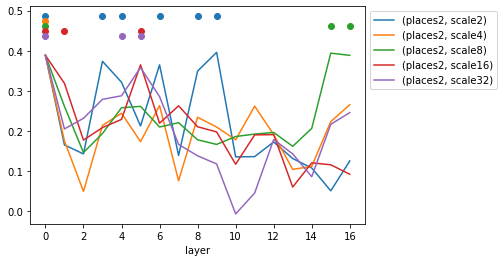

In [63]:
correlations_with_model.groupby("dataset").apply(sem2d3d_plot_modelcorr)

### plots

#### all nets unblocked

#### sem2d3d nets unblocked

In [ ]:
pl = (
    correlations_with_model.unstack("layer")
    .correlation.groupby("dataset")
    .apply(lambda x: x.T.plot())
)

#### sem2d3d nets average

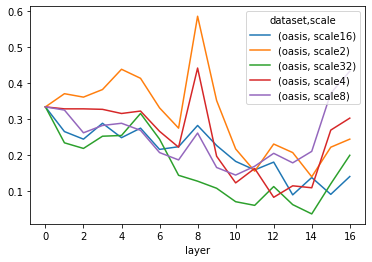

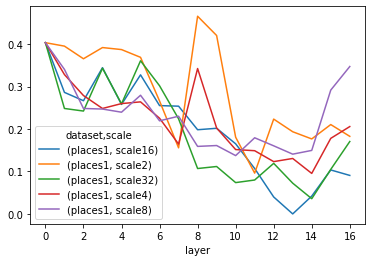

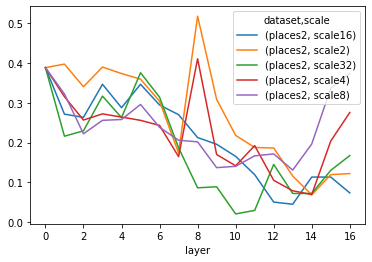

In [61]:
pl = (
    correlations_with_model.loc[(slice(None), slice(None), slice(None))]
    .unstack("layer")
    .correlation.groupby("dataset")
    .apply(lambda x: x.T.plot(subplots=False))
)

#### sem2d3dnets maxpool

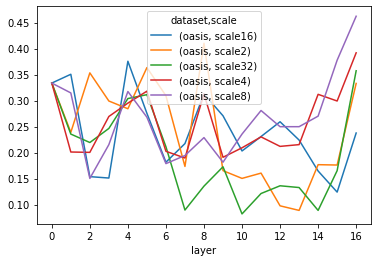

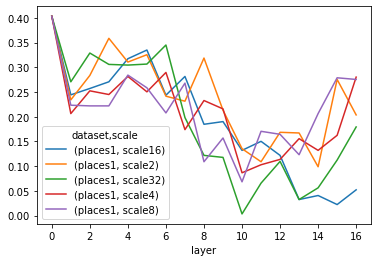

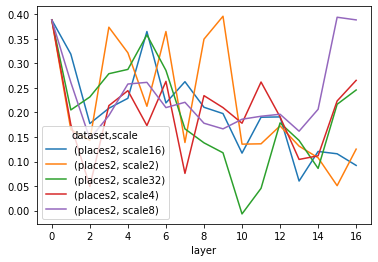

In [12]:
pl = (
    correlations_with_model.loc[(slice(None), slice(None), slice(None))]
    .unstack("layer")
    .correlation.groupby("dataset")
    .apply(lambda x: x.T.plot(subplots=False))
)

### add network classes to data

In [ ]:
# add network classes to data

# integration
dfi = dfi.loc[NETS_ALL]
dfi["class"] = dfi.reset_index(level="model").model.apply(modelname2class).values
dfi = dfi.set_index("class", append=True)

dfi_m = dfi_m.loc[NETS_ALL]
dfi_m["class"] = dfi_m.reset_index(level="model").model.apply(modelname2class).values
dfi_m = dfi_m.set_index("class", append=True)


# ibcorr
dfibc = dfibc.loc[NETS_ALL]
dfibc["class"] = dfibc.reset_index(level="model").model.apply(modelname2class).values
dfibc = dfibc.set_index("class", append=True)

dfibc_m = dfibc_m.loc[NETS_ALL]
dfibc_m["class"] = (
    dfibc_m.reset_index(level="model").model.apply(modelname2class).values
)
dfibc_m = dfibc_m.set_index("class", append=True)

In [ ]:
# model RDM
model_rdm = pd.DataFrame(
    np.full((len(NETS_ALL), len(NETS_ALL)), np.nan), columns=NETS_ALL, index=NETS_ALL
)

for combi in combinations_with_replacement(NETS_ALL, 2):
    if (
        combi in combinations_with_replacement(NETS_SEMANTIC, 2)
        or combi in combinations_with_replacement(NETS_2D, 2)
        or combi in combinations_with_replacement(NETS_3D, 2)
    ):
        model_rdm.loc[combi] = 1
        model_rdm.loc[tuple(reversed(combi))] = 1
    else:
        model_rdm.loc[combi] = 0
        model_rdm.loc[tuple(reversed(combi))] = 0

sns.heatmap(model_rdm, cmap="viridis")

### variance partitioning

MODEL RDM as target,  steps as predictors <br>
shared variance between any of the models, subsequent added explained variance by each of the steps

In [ ]:
# get beauty predictions for images from best predicting model in each layer for each class
bestnets = (
    dfibc_m.unstack("layer")
    .groupby("class")
    .aggregate(lambda c: c.idxmax()[0])
    .stack("layer")
    .rename({"ibcorr": "net"}, axis=1)
    .reset_index()
    .values.tolist()
)
dfi_m_best = (
    dfi_m.unstack("img")
    .reorder_levels(["class", "layer", "model"])
    .loc[bestnets, :]
    .droplevel("model")
    .stack("img")
    #    .unstack("layer")
)

In [ ]:
dfi_m_best

In [ ]:
ibcorr_from_classmaxpool = (
    dfi_m_best.groupby(["layer", "class"])
    .aggregate(lambda i: pearsonr(-i, beauty_ratings["study1_places1_short.csv"])[0][0])
    .unstack("class")
)
ibcorr_from_classmaxpool.plot()

In [ ]:
# average beauty prediction (i.e. integration) for each image from each class
# since the ib-correlation is the spearman correlation. Just do OLS variance partitioning for now an then talk to daniel about it.
ibcorr_from_classmaxpool = (
    dfi_m_best.groupby(["layer", "class"])
    .aggregate(lambda i: pearsonr(-i, beauty_ratings["study1_places1_short.csv"])[0][0])
    .unstack("class")
)
ibcorr_from_classmaxpool.plot()

ibcorr_from_classavg = (
    dfi_m.groupby(["class", "layer", "img"])
    .mean()
    .groupby(["layer", "class"])
    .aggregate(lambda i: pearsonr(-i, beauty_ratings["study1_places1_short.csv"])[0][0])
    .unstack("class")
)
ibcorr_from_classavg.plot()

In [ ]:
dfi_m_classavg = dfi_m.groupby(["class", "layer", "img"]).mean().unstack("class")
dfi_m_classavg

In [ ]:
beauty_ratings["study1_places1_short.csv"].values.squeeze()

In [ ]:
dfi_m_classavg.loc[:, (slice(None), "2d")]

In [ ]:
r2_all = dfi_m_classavg.groupby(["layer"]).apply(
    lambda X: OLS(beauty_ratings["study1_places1_short.csv"].values.squeeze(), X.values)
    .fit()
    .rsquared
)

In [ ]:
r2_semantic = r2_all - dfi_m_classavg.loc[:, (slice(None), ["2d", "3d"])].groupby(
    ["layer"]
).apply(
    lambda X: OLS(beauty_ratings["study1_places1_short.csv"].values.squeeze(), X.values)
    .fit()
    .rsquared
)

r2_2d = r2_all - dfi_m_classavg.loc[:, (slice(None), ["semantic", "3d"])].groupby(
    ["layer"]
).apply(
    lambda X: OLS(beauty_ratings["study1_places1_short.csv"].values.squeeze(), X.values)
    .fit()
    .rsquared
)


r2_3d = r2_all - dfi_m_classavg.loc[:, (slice(None), ["semantic", "2d"])].groupby(
    ["layer"]
).apply(
    lambda X: OLS(beauty_ratings["study1_places1_short.csv"].values.squeeze(), X.values)
    .fit()
    .rsquared
)

In [ ]:
plt.plot(r2_3d, label="3d")
plt.plot(r2_2d, label="2d")
plt.plot(r2_semantic, label="semantic")
plt.legend()

In [ ]:
# create linear model
# single study & layer
dataset = "places1"
layer_idx = 48

df_icr.loc[dataset, layer_idx]

OLS(Y, X).fit().rsquared

In [ ]:
def do_variance_partitioning():
    # do variance partitioning for one layer
    # i.e. for all unique, shared and full combinations of the three predictors
    # return dataframe with all R2 values
     

## semantic, 2d, 3d along layers

### image activations

### raw integration amount


In [ ]:
# get beauty predictions for images from best predicting model in each layer for each class
bestnets = (
    dfibc_m.unstack("layer")
    .groupby("class")
    .aggregate(lambda c: c.idxmax()[0])
    .stack("layer")
    .rename({"ibcorr": "net"}, axis=1)
    .reset_index()
    .values.tolist()
)
dfi_m_best = (
    dfi_m.unstack("img")
    .reorder_levels(["class", "layer", "model"])
    .loc[bestnets, :]
    .droplevel("model")
    .stack("img")
    #    .unstack("layer")
)

In [ ]:
dfi_m_best

In [ ]:
ibcorr_from_classmaxpool = (
    dfi_m_best.groupby(["layer", "class"])
    .aggregate(lambda i: pearsonr(-i, beauty_ratings["study1_places1_short.csv"])[0][0])
    .unstack("class")
)
ibcorr_from_classmaxpool.plot()

In [ ]:
# average beauty prediction (i.e. integration) for each image from each class
# since the ib-correlation is the spearman correlation. Just do OLS variance partitioning for now an then talk to daniel about it.
ibcorr_from_classmaxpool = (
    dfi_m_best.groupby(["layer", "class"])
    .aggregate(lambda i: pearsonr(-i, beauty_ratings["study1_places1_short.csv"])[0][0])
    .unstack("class")
)
ibcorr_from_classmaxpool.plot()

ibcorr_from_classavg = (
    dfi_m.groupby(["class", "layer", "img"])
    .mean()
    .groupby(["layer", "class"])
    .aggregate(lambda i: pearsonr(-i, beauty_ratings["study1_places1_short.csv"])[0][0])
    .unstack("class")
)
ibcorr_from_classavg.plot()

In [ ]:
dfi_m_classavg = dfi_m.groupby(["class", "layer", "img"]).mean().unstack("class")
dfi_m_classavg

In [ ]:
beauty_ratings["study1_places1_short.csv"].values.squeeze()

In [ ]:
dfi_m_classavg.loc[:, (slice(None), "2d")]

In [ ]:
r2_all = dfi_m_classavg.groupby(["layer"]).apply(
    lambda X: OLS(beauty_ratings["study1_places1_short.csv"].values.squeeze(), X.values)
    .fit()
    .rsquared
)

In [ ]:
r2_semantic = r2_all - dfi_m_classavg.loc[:, (slice(None), ["2d", "3d"])].groupby(
    ["layer"]
).apply(
    lambda X: OLS(beauty_ratings["study1_places1_short.csv"].values.squeeze(), X.values)
    .fit()
    .rsquared
)

r2_2d = r2_all - dfi_m_classavg.loc[:, (slice(None), ["semantic", "3d"])].groupby(
    ["layer"]
).apply(
    lambda X: OLS(beauty_ratings["study1_places1_short.csv"].values.squeeze(), X.values)
    .fit()
    .rsquared
)


r2_3d = r2_all - dfi_m_classavg.loc[:, (slice(None), ["semantic", "2d"])].groupby(
    ["layer"]
).apply(
    lambda X: OLS(beauty_ratings["study1_places1_short.csv"].values.squeeze(), X.values)
    .fit()
    .rsquared
)

In [ ]:
plt.plot(r2_3d, label="3d")
plt.plot(r2_2d, label="2d")
plt.plot(r2_semantic, label="semantic")
plt.legend()

In [ ]:
# create linear model
# single study & layer
dataset = "places1"
layer_idx = 48

df_icr.loc[dataset, layer_idx]

OLS(Y, X).fit().rsquared

In [ ]:
def do_variance_partitioning():
    # do variance partitioning for one layer
    # i.e. for all unique, shared and full combinations of the three predictors
    # return dataframe with all R2 values
     

## semantic, 2d, 3d along layers

### image activations

### raw integration amount


In [ ]:
# average integration of layers
df_int_netavg = df1.groupby("model").mean().transpose()
handles, labels = df_int_netavg.plot().get_legend_handles_labels()

# already order legend by classes
order = [labels.index(netname) for netname in NETS_ALL]
plt.legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    loc="center right",
    bbox_to_anchor=(1.5, 0.5),
)

In [ ]:
# average integration, grouped by semantic-2d-3d
colors = (
    len(NETS_SEMANTIC) * ["green"]
    + len(NETS_2D) * ["purple"]
    + len(NETS_3D) * ["orange"]
)

for (netname, int_netavg), color in zip(df_int_netavg.iloc[:, order].items(), colors):
    if netname in NETS_SEMANTIC:
        alpha = 0.7
    else:
        alpha = 0.3
    plt.plot(int_netavg, label=netname, color=color, alpha=alpha)
    plt.legend(loc="center right", bbox_to_anchor=(1.5, 0.5))

#### dev: single layer

In [ ]:
layer_id = 48

# fitler relevant data
layer_df = pd.DataFrame(df.loc[NETS_ALL, "places1", "scale8"][layer_id]).reset_index()
# needed for pivot into wide format
layer_df["img_id"] = layer_df.groupby("model").cumcount()

# pivot
layer_df = layer_df.pivot(columns="model", index="img_id", values=layer_id)

# reorder columns according to semantic-2D-3D nets
layer_df = layer_df[NETS_ALL]

rdm = calculate_rdm(layer_df, correlation_type="spearman")

pearsonr(rdm.values.flatten(), model_rdm.values.flatten())

In [ ]:
pearsonr(rdm.values.flatten(), model_rdm.values.flatten())

In [ ]:
sns.heatmap(rdm, cmap="viridis")

In [ ]:
xdm = rdm[rdm > 0.142].fillna(0)
sns.heatmap(xdm, cmap="viridis")

In [ ]:
xdm = rdm[rdm < 0].fillna(0)
sns.heatmap(xdm, cmap="viridis")

#### all layers

In [ ]:
dfi

In [ ]:
model_correlations = []
model_pvalues = []
# iterate layers
for layer_name, layer_series in df.loc[:, "places1", "scale8"].items():

    # put data back into DataFrame
    layer_df = pd.DataFrame(layer_series).reset_index()

    # needed for pivot into wide format
    layer_df["img_id"] = layer_df.groupby("model").cumcount()

    # pivot
    layer_df = layer_df.pivot(columns="model", index="img_id", values=layer_name)

    # reorder columns according to semantic-2D-3D nets
    layer_df = layer_df[NETS_ALL]

    rdm = calculate_rdm(layer_df, correlation_type="spearman")

    model_correlations.append(
        pearsonr(rdm.values.flatten(), model_rdm.values.flatten())[0]
    )
    model_pvalues.append(pearsonr(rdm.values.flatten(), model_rdm.values.flatten())[1])

In [ ]:
alpha = 0.05

sns.lineplot(data=model_correlations)
plt.suptitle("Similarity in what is integrated")
plt.title("Correlation of taskonomy RDM with model (semantic-2D-3D) RDM")
plt.xlabel("Layer")
plt.ylabel("pearson correlation")


for x, layer_pvalue in enumerate(model_pvalues):
    if layer_pvalue < alpha:
        plt.scatter(x, 0, color="cyan", s=100, marker="o")

### ibcorr differences

## inspect class average integration

In [ ]:
# per class best and worst prediction from individual nets
Y1 = dfibc_m.groupby(["layer", "class"]).agg([min, max])
Y2 = (
    dfi_m.groupby(["class", "layer", "img"])
    .mean()
    .groupby(["layer", "class"])
    .aggregate(lambda i: spearmanr(i, beauty_ratings["study1_places1_short.csv"])[0])
    .unstack("class")
)

In [ ]:
_, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

modelclass = "semantic"
axes[0].fill_between(
    Y1.loc[(slice(None), modelclass), :].index.get_level_values("layer"),
    Y1.loc[(slice(None), modelclass), (slice(None), "min")].values.flat,
    Y1.loc[(slice(None), modelclass), (slice(None), "max")].values.flat,
)
axes[0].plot(-Y2.loc[:, (slice(None), modelclass)], c="red")

modelclass = "2d"
axes[1].fill_between(
    Y1.loc[(slice(None), modelclass), :].index.get_level_values("layer"),
    Y1.loc[(slice(None), modelclass), (slice(None), "min")].values.flat,
    Y1.loc[(slice(None), modelclass), (slice(None), "max")].values.flat,
)
axes[1].plot(-Y2.loc[:, (slice(None), modelclass)], c="red")

modelclass = "3d"
axes[2].fill_between(
    Y1.loc[(slice(None), modelclass), :].index.get_level_values("layer"),
    Y1.loc[(slice(None), modelclass), (slice(None), "min")].values.flat,
    Y1.loc[(slice(None), modelclass), (slice(None), "max")].values.flat,
)
axes[2].plot(-Y2.loc[:, (slice(None), modelclass)], c="red")

## predictor RDM (semantic-2d-3d)

Extend [model rdm](#model-rdm) to contain all models to use as predictor. Fill values for models not belonging to any class with zeros.

In [ ]:
predictor_rdm_1 = pd.DataFrame(0, index=_models, columns=_models)
for c1, c2 in combinations_with_replacement(_models, 2):
    if c1 in model_rdm.index and c2 in model_rdm.index:
        predictor_rdm_1.loc[c1, c2] = 1 - model_rdm.loc[c1, c2]
        predictor_rdm_1.loc[c2, c1] = 1 - model_rdm.loc[c2, c1]
    else:
        predictor_rdm_1.loc[c1, c2] = 0
        predictor_rdm_1.loc[c2, c1] = 0

# Predictor 2:  integration profile across layers

RDM of RDM's that correlate integration ratings of each different layers inside each network.

[Finished predictor RDM](#predictor-rdm-layer-layer-similarity-inside-networks)

TODO: this essentially the same thing as absoloute correlation differences alone ?
copy code for each models layerXlayer RDM
correlate correlations using daniels code

## version 1: layer X layer RDM for each network

In [215]:
dfi = dfi.unstack("layer")

In [218]:
factor2_rdms = dfi.groupby(["dataset", "scale","model"]).apply(calculate_rdm)

In [ ]:
factor2_rdms.to_hdf(os.path.join(PATH_RESULTS, "layer profile", "all_maxpoool.h5"), key="factor2_rdms")

In [65]:
factor2_rdms = pd.read_hdf(
    os.path.join(PATH_RESULTS, "layer profile", "all_maxpoool.h5"), key="factor2_rdms"
)

/home/max/miniconda3/envs/PytorchEnv/lib/python3.8/site-packages/pandas/io/pytables.py:3007: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  index = factory(


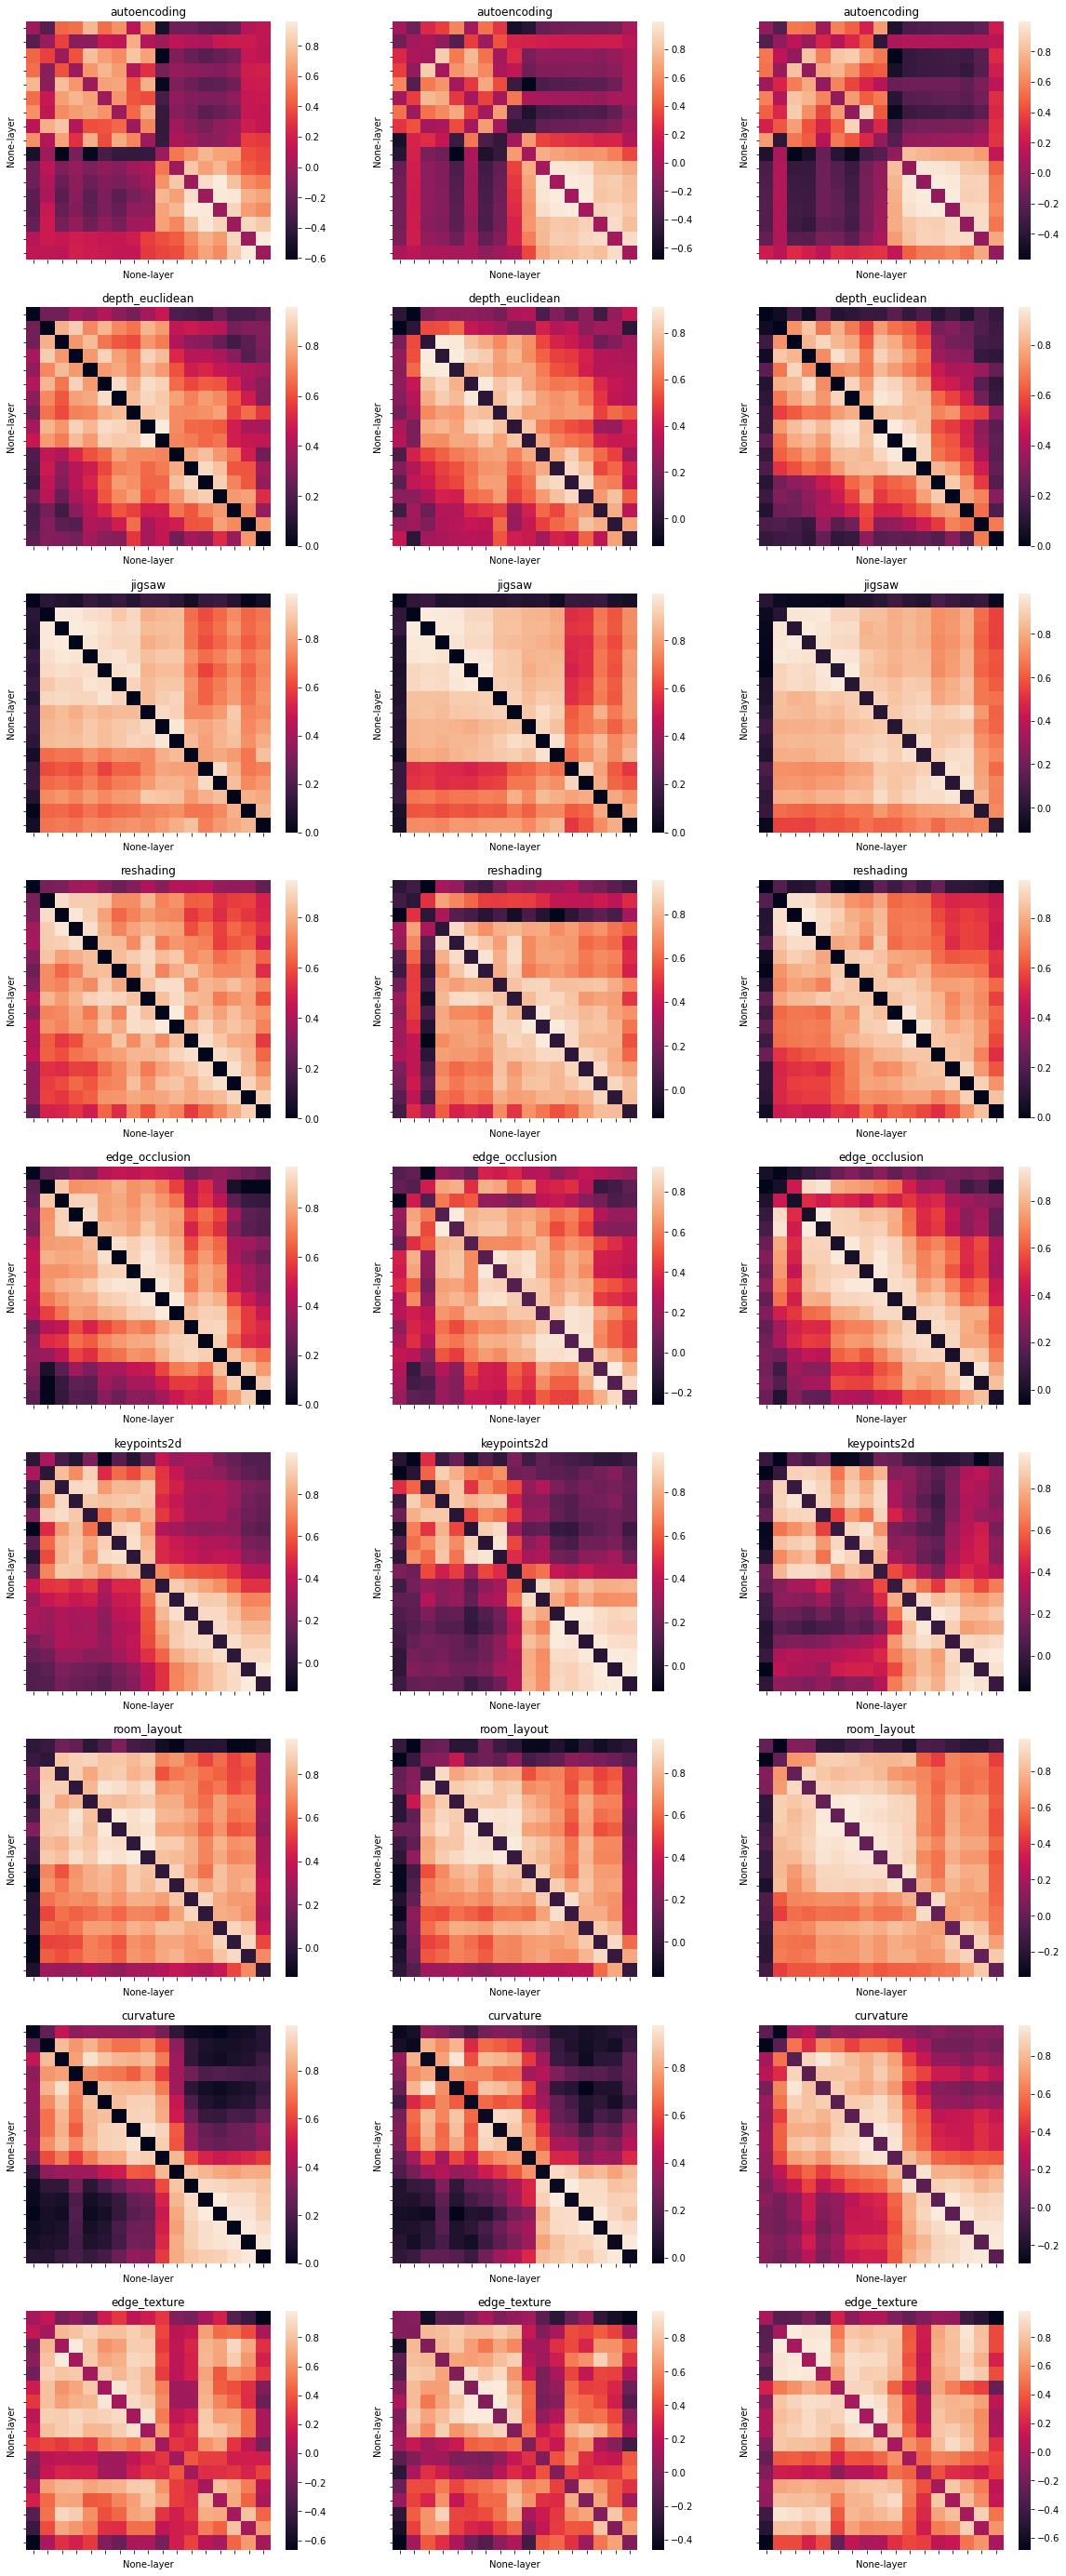

In [294]:
fig, axes = plt.subplots(9,3, figsize=(20,50))

for (mo, da), ax in zip(product(MODEL_NAMES[:10], DATASET_NAMES), axes.flat):
    #ax.plot(tmp.loc[(da, "scale4", mo)])
    ax.set_title(mo)
    sns.heatmap(factor2_rdms.loc[(da, "scale4", mo)], ax=ax)
    ax.set_xticklabels("")
    ax.set_yticklabels("")

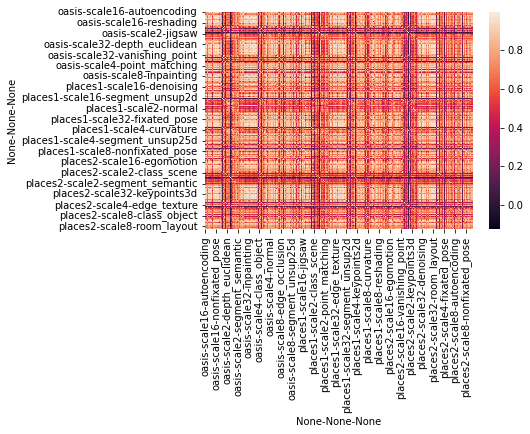

In [66]:
g = factor2_rdms.groupby(["dataset", "scale", "model"])


parameters = g.groups.keys()
rdm = pd.DataFrame(np.nan, index=parameters, columns=parameters)

for p1, p2 in combinations(parameters, 2):
    rdm.loc[p1, p2] = correlate_rdms(g.get_group(p1), g.get_group(p2))[0]
    rdm.loc[p2, p1] = rdm.loc[p1, p2]

sns.heatmap(rdm)
factor2_rdm_alllayers = rdm

In [ ]:
model_rdm_networks = pd.DataFrame(0, index=parameters, columns=parameters)

for (da1, sc1, mo1), (da2, sc2, mo2) in combinations(parameters, 2):
    if mo1 == mo2:
        model_rdm_networks.loc[(da1, sc1, mo1), (da2, sc2, mo2)] = 1
        model_rdm_networks.loc[(da2, sc2, mo2), (da1, sc1, mo1)] = 1

sns.heatmap(model_rdm_networks)

In [ ]:
model_rdm_scales = pd.DataFrame(0, index=parameters, columns=parameters)

for (da1, sc1, mo1), (da2, sc2, mo2) in combinations(parameters, 2):
    if sc1 == sc2:
        model_rdm_scales.loc[(da1, sc1, mo1), (da2, sc2, mo2)] = 1
        model_rdm_scales.loc[(da2, sc2, mo2), (da1, sc1, mo1)] = 1

sns.heatmap(model_rdm_scales)

In [ ]:
model_rdm_datasets = pd.DataFrame(0, index=parameters, columns=parameters)

for (da1, sc1, mo1), (da2, sc2, mo2) in combinations(parameters, 2):
    if da1 == da2:
        model_rdm_datasets.loc[(da1, sc1, mo1), (da2, sc2, mo2)] = 1
        model_rdm_datasets.loc[(da2, sc2, mo2), (da1, sc1, mo1)] = 1

sns.heatmap(model_rdm_datasets)

In [288]:
correlate_rdms(rdm, model_rdm_networks)

(0.13999851051400078, 2.0837638018633766e-257)

In [289]:
correlate_rdms(rdm, model_rdm_scales)

(0.07561375395378075, 5.679552525448072e-76)

In [290]:
correlate_rdms(rdm, model_rdm_datasets)

(0.008736605822776671, 0.033319200094115306)

## version 2: integration in best layer

ordering of images by integration in best predicting layer

"what is integrated", alternatively average of correlation between in each layer, howevery layers may not correspond to each other, therefore best predicting layer is more general <br> <br>

Interpretation: The differences in absolout values correspond to how similar the "integration mechanism" in both networks are.<br> If we assume that beauty perception depends on a specific stage of processing and not the whole processing stream, then the best predicting layer of a network can be interpreted as the point, where the network best mimics the aspects of the processing that determine beauty. <br> 

If the a similar The value in Is there a single or are there different ways of predicting beauty ?`

In [197]:
bestlayers = (
    dfibc.groupby(["study", "scale", "model"])
    .idxmax()
    .ibcorr.transform(lambda idx: idx[-1])
    .to_frame()
    .reset_index()
    .values.tolist()
)

In [198]:
dfi2 = dfi.reorder_levels(("dataset","scale","model","layer", "img"))

dfi2.index = dfi2.index.set_names(level="dataset", names="study").set_levels(
    dfi2.index.levels[0].map(
        {
            "places1": "short presentation",
            "places2": "complexity order",
            "oasis": "oasis",
        }
    ),level="study"
)

dfi2_longpresentation = (
    dfi2.loc["short presentation"]
    .assign(study="long presentation")
    .set_index("study", append=True)
    .reorder_levels(("study", "scale", "model", "layer", "img"))
)
dfi_studies = pd.concat((dfi2, dfi2_longpresentation))

In [202]:
df_best_integration = (
    dfi_studies.unstack("img").loc[bestlayers].droplevel("layer").stack("img")
)

In [211]:
factor2_rdm_bestlayer = (
    df_best_integration.unstack("model")
    .groupby(["study", "scale"])
    .apply(calculate_rdm)
)

# Predictor 3: spatial integration

"how"

"where" or alternatively "what",  which is the same because its spatial integration. Check for correlation between the what (represented by the integration ratings).

DONE IN SEPERATE NOTEBOOK

In [ ]:
# # import results
# with open(os.path.join(PATH_RESULTS, "spatial integration", "study1.pkl"), "rb") as f:
#     d1 = pickle.load(f)

# with open(os.path.join(PATH_RESULTS, "spatial integration", "study2.pkl"), "rb") as f:
#     d2 = pickle.load(f)

# with open(os.path.join(PATH_RESULTS, "spatial integration", "study3.pkl"), "rb") as f:
#     d3 = pickle.load(f)

# with open(os.path.join(PATH_RESULTS, "spatial integration", "study4.pkl"), "rb") as f:
#     d4 = pickle.load(f)


# rdm_study1 = calculate_rdm(flatten_concat(d1))
# rdm_study2 = calculate_rdm(flatten_concat(d2))
# rdm_study3 = calculate_rdm(flatten_concat(d3))
# rdm_study4 = calculate_rdm(flatten_concat(d4))

In [ ]:
_studies = "short presentation"
_scales = "scale4"


rdms = {}

for mo in _models:
    rdm = pd.read_csv(
        os.path.join(
            PATH_RESULTS,
            "spatial integration",
            _scales,
            _studies,
            mo + ".csv",
        ),
        header=None,
    )
    rdm = rdm.iloc[1:, 1:].reset_index(drop=True).T.reset_index(drop=True).T

    rdms[mo] = rdm

In [11]:
factor3_rdms = pd.read_hdf(
    os.path.join(
        PATH_RESULTS,
        "spatial integration",
        "scale4",
        "rdms " + "short presentation" + " allnets.h5",
    ),
    key="dfspi_rdms",
)

In [ ]:
predictor_rdm_3 = pd.DataFrame(0, index=MODEL_NAMES, columns=MODEL_NAMES)
g = factor3_rdms.groupby("model")

for gk1, gk2 in combinations(g.groups.keys(), 2):
    c = correlate_rdms(g.get_group(gk1), g.get_group(gk2))[0]
    predictor_rdm_3.loc[gk1, gk2], predictor_rdm_3.loc[gk2, gk1] = c, c

In [155]:
#sns.heatmap(spatial_rdm, xticklabels=spatial_rdm.index, yticklabels=spatial_rdm.columns)

## integration is localized

In [ ]:
# visualize node score distribution

In [ ]:
# visualize within layer heatmaps

# exemplars

In [ ]:
# spatial correlation per image per net, correlate these netXnet
# test if integration scores are still correlating to beauty

## predictor RDM

In [ ]:
predictor_rdm_3 = predictor_rdm_3

# Predictors-Target analysis
do for each study and each scale, to check if there is some consistency in which factors always comes out on top



In [ ]:
target_rdm = target_rdm_absdiff.loc[("short presentation", "scale4")]

In [149]:
t = rdm2vec(target_rdm)

In [ ]:
# variance partitioning
def predictor_r2(predictors: list[pd.DataFrame], target):
    predictors = np.stack([rdm2vec(_rdm).transpose() for _rdm in predictors], axis=1)
    predictors = sm.add_constant(predictors)
    model = sm.OLS(target, predictors)
    results = model.fit()
    return results.rsquared

## predictor 1 - target

In [143]:
pearsonr(p1, t)

(0.07931940015309769, 0.20861366351184038)

In [150]:
correlate_rdms(predictor_rdm_1.loc[NETS_ALL, NETS_ALL], target_rdm.loc[NETS_ALL, NETS_ALL])

(-0.29001848514913353, 0.002690861862071442)

In [193]:
predictor_rdm_1.shape

(23, 23)

In [201]:
predictor_rdm_1.shape

(23, 23)

In [199]:
target_rdm.shape

(23, 23)

In [203]:
predictor_rdm_1

,autoencoding,depth_euclidean,jigsaw,reshading,edge_occlusion,keypoints2d,room_layout,curvature,edge_texture,keypoints3d,...,nonfixated_pose,segment_unsup25d,class_scene,fixated_pose,normal,segment_semantic,denoising,inpainting,point_matching,vanishing_point
autoencoding,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0
depth_euclidean,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
jigsaw,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
reshading,0,0,0,1,1,0,0,1,0,1,...,0,1,0,0,1,0,0,0,0,0
edge_occlusion,0,0,0,1,1,0,0,1,0,1,...,0,1,0,0,1,0,0,0,0,0
keypoints2d,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0
room_layout,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
curvature,0,0,0,1,1,0,0,1,0,1,...,0,1,0,0,1,0,0,0,0,0
edge_texture,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0
keypoints3d,0,0,0,1,1,0,0,1,0,1,...,0,1,0,0,1,0,0,0,0,0


In [202]:
target_rdm

model,autoencoding,class_object,class_scene,curvature,denoising,depth_euclidean,edge_occlusion,edge_texture,egomotion,fixated_pose,...,keypoints3d,nonfixated_pose,normal,point_matching,reshading,room_layout,segment_semantic,segment_unsup25d,segment_unsup2d,vanishing_point
model,,,,,,,,,,,,,,,,,,,,,
autoencoding,0.000000,8.720643,10.245462,11.560273,2.300163,12.354460,10.751507,10.301925,7.106467,6.932489,...,12.777257,7.820332,14.337799,5.792216,11.865939,12.802817,11.361108,11.190042,14.144350,14.067232
class_object,8.720643,0.000000,4.668494,5.136402,7.711176,5.873315,4.239254,6.203500,3.037687,5.160542,...,6.125608,4.166002,7.775462,4.763991,5.782873,6.468299,5.207982,4.613443,7.488759,7.592471
class_scene,10.245462,4.668494,0.000000,2.879982,10.086942,3.535304,3.428632,6.583889,4.260549,4.217045,...,4.197462,3.741955,5.009428,5.378213,3.684291,4.051652,4.766741,3.829726,4.673175,5.842049
curvature,11.560273,5.136402,2.879982,0.000000,11.365260,3.044653,2.693327,6.381715,5.287630,5.182675,...,2.431945,4.465542,3.348786,6.387933,3.107249,3.392399,4.252471,3.439570,3.776034,4.535102
denoising,2.300163,7.711176,10.086942,11.365260,0.000000,12.275121,10.574539,9.634885,6.617355,6.606753,...,12.598871,7.570361,14.035662,5.296382,11.580376,12.425291,10.931290,11.023551,13.924655,13.872750
depth_euclidean,12.354460,5.873315,3.535304,3.044653,12.275121,0.000000,3.421892,6.412434,6.014866,6.771651,...,4.068905,5.460561,4.662241,7.427933,4.654122,4.612069,3.654886,3.587521,4.566941,4.746871
edge_occlusion,10.751507,4.239254,3.428632,2.693327,10.574539,3.421892,0.000000,5.702883,4.151657,5.579604,...,3.002468,3.929731,4.594565,5.812893,3.661489,4.355596,4.170364,2.573414,4.385174,4.574199
edge_texture,10.301925,6.203500,6.583889,6.381715,9.634885,6.412434,5.702883,0.000000,5.911384,6.865827,...,6.289865,6.274059,6.919198,6.697624,6.404736,6.962430,6.270901,6.233728,6.381317,6.224500
egomotion,7.106467,3.037687,4.260549,5.287630,6.617355,6.014866,4.151657,5.911384,0.000000,3.713580,...,6.462083,2.150931,7.955973,2.892818,5.264403,6.518689,5.340730,5.019808,7.432338,7.435854


In [197]:
predictors_r2(predictor_rdm_1, target_rdm)

ValueError: The indices for endog and exog are not aligned

In [152]:
predictors_r2(rdm2vec(predictor_rdm_1.loc[NETS_ALL, NETS_ALL]), rdm2vec(target_rdm.loc[NETS_ALL, NETS_ALL]))

0.08411072172819822

## predictor2 - target

In [ ]:
f2 = factor2_rdm_alllayers.loc[("places1","scale4"),("places1","scale4")]

In [162]:
f2

,autoencoding,class_object,class_scene,curvature,denoising,depth_euclidean,edge_occlusion,edge_texture,egomotion,fixated_pose,...,keypoints3d,nonfixated_pose,normal,point_matching,reshading,room_layout,segment_semantic,segment_unsup25d,segment_unsup2d,vanishing_point
autoencoding,NaN,0.120553,0.099613,0.620845,0.440686,0.259606,0.274870,0.164451,0.135081,0.337666,...,0.316053,0.186518,0.294447,0.382980,0.302508,0.229970,0.222017,0.442672,0.181739,0.161203
class_object,0.120553,NaN,0.953411,0.465710,0.211930,0.789665,0.815153,0.611867,0.702120,0.816970,...,0.797041,0.872127,0.765332,0.792897,0.761156,0.865824,0.892269,0.720315,0.890437,0.547735
class_scene,0.099613,0.953411,NaN,0.430506,0.172858,0.751446,0.789595,0.633328,0.712859,0.808762,...,0.758076,0.865919,0.704542,0.768783,0.714887,0.845796,0.828347,0.675602,0.876735,0.558356
curvature,0.620845,0.465710,0.430506,NaN,0.454310,0.705277,0.733410,0.345621,0.544716,0.757458,...,0.713664,0.516564,0.644461,0.566034,0.633795,0.539563,0.578745,0.747232,0.525738,0.347146
denoising,0.440686,0.211930,0.172858,0.454310,NaN,0.292887,0.307077,0.124808,0.355372,0.278492,...,0.342935,0.235345,0.282192,0.323240,0.297910,0.284873,0.357725,0.467063,0.232370,0.348321
depth_euclidean,0.259606,0.789665,0.751446,0.705277,0.292887,NaN,0.873849,0.529081,0.740228,0.868674,...,0.851096,0.767064,0.852270,0.710028,0.800894,0.784920,0.818985,0.783113,0.788529,0.593360
edge_occlusion,0.274870,0.815153,0.789595,0.733410,0.307077,0.873849,NaN,0.495538,0.799273,0.861582,...,0.895906,0.803852,0.869334,0.752845,0.754991,0.724061,0.793679,0.794493,0.843540,0.514947
edge_texture,0.164451,0.611867,0.633328,0.345621,0.124808,0.529081,0.495538,NaN,0.473085,0.669166,...,0.494097,0.605675,0.420897,0.606588,0.519230,0.660563,0.602655,0.493007,0.580108,0.638222
egomotion,0.135081,0.702120,0.712859,0.544716,0.355372,0.740228,0.799273,0.473085,NaN,0.809485,...,0.707248,0.766920,0.632728,0.701396,0.603666,0.692742,0.607930,0.649462,0.760676,0.632246
fixated_pose,0.337666,0.816970,0.808762,0.757458,0.278492,0.868674,0.861582,0.669166,0.809485,NaN,...,0.851196,0.871330,0.749030,0.833729,0.812376,0.870863,0.814144,0.777113,0.864980,0.652590


In [72]:
correlate_rdms(t, f2)

(-0.6677444638211117, 4.977027167376115e-34)

In [214]:
f2  = factor2_rdm_bestlayer.loc[("short presentation","scale4")]

In [228]:
correlate_rdms(t, f2)

(-0.5236855635420519, 3.2151495763391566e-19)

In [ ]:
factor2_rdm_bestlayer

In [222]:
target_rdm_absdiff.groupby(["study","scale"])

In [ ]:
for (name1, group1), (name2, group2) in zip(factor2_rdm_bestlayer.groupby(["study","scale"]), target_rdm_absdiff.groupby(["study","scale"])):
    print(name1==name2)

In [236]:
rdm2vec(f2), rdm2vec(t);

In [237]:
predictors_r2(rdm2vec(f2), rdm2vec(t))

0.3648911015205908

## predictor 3 - target

In [ ]:
f3 = factor3_rdm

In [ ]:
correlate_rdms(f3, t)

(-0.37464126075879833, 7.500535101774924e-10)

In [ ]:
predictors_r2(rdm2vec(f3), rdm2vec(t))

0.14035607426294194

In [ ]:
spearmanr(t, p3)

In [ ]:
plt.scatter(t, p3, s=10, color="magenta")

In [ ]:
sns.kdeplot(pd.DataFrame((t, p3)).T, x=0, y=1, fill=True,levels=100)
plt.scatter(t, p3, s=10, color="magenta")
plt.xlim(0,t.max())
plt.ylim(0,p1.max())

In [ ]:
plt.scatter(t.argsort(), p3.argsort(), s=10, color="magenta")

In [ ]:
sns.kdeplot(pd.DataFrame((t.argsort(), p3.argsort())).T, x=0, y=1, fill=True,levels=3)
plt.scatter(t.argsort(), p3.argsort(), s=10, color="magenta")
plt.xlim(0,t.size)
plt.ylim(0,t.size)

## variance partitioning

In [ ]:
predictors_r2(p1, t), predictors_r2(p2, t), predictors_r2(p3, t)

In [ ]:
predictors_r2(np.stack((p1, p3), axis=1), t) - predictors_r2(p3, t)

In [ ]:
# plot full venn diagram (with 2 or 3 predictors)